In [2]:
import torch
from tqdm import tqdm
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
from sklearn.cluster import KMeans
import imageio
import os
import copy

In [3]:
X = np.array([
    [1] * 6,
    [2] * 6,
    [3] * 6,
])

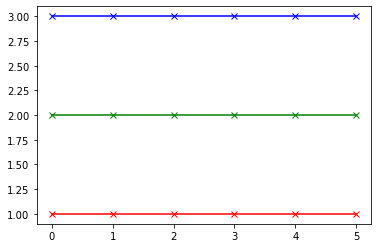

In [4]:
plt.plot(range(6), X[0], marker='x', c='r')
plt.plot(range(6), X[1], marker='x', c='g')
plt.plot(range(6), X[2], marker='x', c='b')
plt.show()

In [5]:
dataset = torch.tensor(X).unsqueeze(1).to(torch.float)
dataset.shape

torch.Size([3, 1, 6])

In [20]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.cnn = nn.Conv1d(1,1,3,1)
        self.max_pool = nn.MaxPool1d(2,1)
        self.lstm_hidden_dim = 1
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=1,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

    def forward(self, x):
        x = self.max_pool(F.relu(self.cnn(x)))
        x = x.permute(0, 2, 1)
        x, (_, _) = self.lstm(x)

        x = x[:, :, : self.lstm_hidden_dim] + x[:, :, self.lstm_hidden_dim :]
        x = x.permute(0,2,1)
        return x

class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Make each time series have 4 elements
        self.upsample = nn.Upsample(size=(4,))
        self.decoder = nn.ConvTranspose1d(1,1,3,1)
    
    def forward(self,x):
        x = self.upsample(x)
        return F.relu(self.decoder(x))


class TAE(nn.Module):
    def __init__(self, encoder, decoder) -> None:
        super().__init__()
        self.encoder = encoder 
        self.decoder = decoder 

    def forward(self, x):
        l = self.encoder(x)
        x_prime = self.decoder(l)
        return l, x_prime


class ClusterLayer(nn.Module):
    def __init__(self, encoder, centroids) -> None:
        super().__init__()
        self.encoder = encoder 
        self.centroids = nn.Parameter(centroids)
    
    def euclidean_distance(self, x, y):
        dists = torch.zeros(3,3)

        for i in range(3):
            d = []
            for j in range(3):
                a = x[i].flatten()
                b = y[j].flatten()
                euc = ((a-b)**2).sum()
                dists[i][j] = euc
        return dists

    def students_t_distribution_kernel(self, x, alpha=1):
        num = torch.pow((1 + x / alpha), -(alpha + 1) / 2)
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, 3)
        return num / denom

    def target_distribution(self, Q):
        F = Q.sum(dim=0)
        num = (Q ** 2) / F
        denom = num.sum(dim=1).reshape(-1, 1).repeat(1, Q.shape[-1])
        return num / denom

    def forward(self, x):
        l = self.encoder(x)
        D = self.euclidean_distance(l, self.centroids)
        Q = self.students_t_distribution_kernel(D)
        P = self.target_distribution(Q)
        return l, torch.log(Q), torch.log(P)

In [21]:
def train_TAE(ae, n_epochs):
    optimizer = optim.Adam(ae.parameters(), lr=0.001)
    criterion = nn.MSELoss()
    sheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        factor=0.5,
        patience=50,
        threshold=0.001
    )

    latents = []
    losses = [] 

    pbar = tqdm(range(n_epochs))

    for i in pbar:
        l, x_prime = ae(dataset)
        loss = criterion(x_prime, dataset)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sheduler.step(loss.item())

        latents.append(l.detach().numpy())
        losses.append(loss.item())
        
        if i % 100 == 0:
            pbar.set_description(f'{round(loss.item(), 6)}')
    return latents, losses

In [142]:
def get_centroids(ae):
    l, x_prime = ae(dataset)
    cs = KMeans(n_clusters=3).fit_predict(l.detach().numpy().squeeze(1))

    centroids = []

    for i in range(3):
        mask = cs == i
        centroids.append(l[mask].mean(dim=2).reshape(1, -1))
    return torch.cat(centroids).detach()

In [143]:
decoder = Decoder()
encoder = Encoder()
ae = TAE(encoder, decoder)

latents, losses = train_TAE(ae, n_epochs=5000)

0.054777: 100%|██████████| 5000/5000 [00:07<00:00, 647.65it/s]


In [144]:
centroids = get_centroids(ae)
centroids = centroids.unsqueeze(1)

In [145]:
cl_main_2 = ClusterLayer(encoder=encoder, centroids=centroids)

In [146]:
centroids

tensor([[[-0.2575]],

        [[ 0.5749]],

        [[ 0.1566]]])

In [84]:
cl = copy.deepcopy(cl_main)

In [85]:
optimizer = optim.SGD(cl.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
mse = nn.MSELoss()
kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

In [113]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


def fit_DTC(cl, weight, output_name):
    optimizer = optim.SGD(cl.parameters(), lr=0.01)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=50, verbose=1)
    mse = nn.MSELoss()
    kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    filenames = []

    last_loss = float('inf')
    tol = 0.00001
    patience_counter = 0
    patience_tol = 1000

    all_losses = []
    all_mse = []
    all_kl = []

    pbar = tqdm(range(100000))

    for i in pbar:
        l, P, Q = cl(dataset)
        x_prime = decoder(l)

        mse_loss = mse(dataset, x_prime)
        kl_loss = kl(Q, P)

        dtc_loss = mse_loss + weight * kl_loss

        all_losses.append(dtc_loss.item())
        all_mse.append(mse_loss.item())
        all_kl.append(kl_loss.item())

        optimizer.zero_grad()
        dtc_loss.backward()
        optimizer.step()

        
        if i % 100 == 0 and i != 0:
            fig, ax = plt.subplots(2,2)

            ls = [x.flatten().detach() for x in l]
            cents = [x.flatten().detach() for x in cl.centroids]

            ax[0][0].plot(range(len(all_mse)), all_mse)
            ax[0][0].set_xlabel('$Epoch$')
            ax[0][0].set_ylabel('$Loss$')
            ax[0][0].set_title(f'MSE')

            ax[0][1].plot(range(len(all_kl)), all_kl)
            ax[0][1].set_xlabel('$Epoch$')
            ax[0][1].set_ylabel('$Loss$')
            ax[0][1].set_title(f'KL Divergence Loss')

            ax[1][0].plot(range(3), ls[0], c='r', label='$L_1$')
            ax[1][0].plot(range(3), ls[1], c='g', label='$L_2$')
            ax[1][0].plot(range(3), ls[2], c='b', label='$L_3$')
            ax[1][0].plot(range(3), cents[0], c='black', label='Centroids')
            ax[1][0].plot(range(3), cents[1], c='black')
            ax[1][0].plot(range(3), cents[2], c='black')
            ax[1][0].set_xlabel('$X$')
            ax[1][0].set_ylabel('$Y$')
            ax[1][0].set_title('Latent space')
            ax[1][0].legend()

            ax[1][1].plot(range(len(all_losses)), all_losses)
            ax[1][1].set_xlabel('$Epoch$')
            ax[1][1].set_ylabel('$Loss$')
            ax[1][1].set_title(f'DTC')

            fig.set_size_inches(25, 15)

            filename = f'temp/img_{i}.png'
            filenames.append(filename)

            plt.savefig(filename)
            plt.close()

            pbar.set_description(f'{round(dtc_loss.item(), 8)}')

        if abs(last_loss - dtc_loss.item()) < tol:
            if patience_counter >= patience_tol:
                break
            patience_counter += 1
        else:
            last_loss = dtc_loss.item()
            patience_counter = 0

        scheduler.step(dtc_loss.item())
        all_losses.append(dtc_loss.item())

    # build gif
    with imageio.get_writer(f'{output_name}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [140]:
cl = copy.deepcopy(cl_main_2)
fit_DTC(cl, 1, 'weight_1_2')

0.19110295: 100%|██████████| 10000/10000 [00:40<00:00, 244.49it/s]


In [141]:
cl = copy.deepcopy(cl_main_2)
fit_DTC(cl, 50, 'weight_1_50')

0.22315156: 100%|██████████| 10000/10000 [00:39<00:00, 255.60it/s]


In [121]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 2, 'weight_2')

0.07495006:   2%|▏         | 2157/100000 [00:08<05:26, 299.57it/s]

Epoch 02159: reducing learning rate of group 0 to 9.0000e-03.


0.07493905:   2%|▏         | 2250/100000 [00:09<05:36, 290.66it/s]

Epoch 02223: reducing learning rate of group 0 to 8.1000e-03.
Epoch 02274: reducing learning rate of group 0 to 7.2900e-03.


0.07493444:   2%|▏         | 2356/100000 [00:09<05:22, 303.09it/s]

Epoch 02376: reducing learning rate of group 0 to 6.5610e-03.


0.07493216:   2%|▏         | 2449/100000 [00:09<05:34, 291.47it/s]

Epoch 02427: reducing learning rate of group 0 to 5.9049e-03.
Epoch 02478: reducing learning rate of group 0 to 5.3144e-03.


0.07493079:   3%|▎         | 2590/100000 [00:10<05:01, 323.57it/s]

Epoch 02529: reducing learning rate of group 0 to 4.7830e-03.
Epoch 02580: reducing learning rate of group 0 to 4.3047e-03.


0.07492993:   3%|▎         | 2685/100000 [00:10<05:14, 309.87it/s]

Epoch 02631: reducing learning rate of group 0 to 3.8742e-03.
Epoch 02682: reducing learning rate of group 0 to 3.4868e-03.


0.07492959:   3%|▎         | 2778/100000 [00:10<05:24, 299.50it/s]

Epoch 02733: reducing learning rate of group 0 to 3.1381e-03.
Epoch 02784: reducing learning rate of group 0 to 2.8243e-03.


0.0749292:   3%|▎         | 2873/100000 [00:11<05:27, 296.76it/s] 

Epoch 02835: reducing learning rate of group 0 to 2.5419e-03.
Epoch 02886: reducing learning rate of group 0 to 2.2877e-03.


0.07492888:   3%|▎         | 2964/100000 [00:11<05:34, 289.80it/s]

Epoch 02937: reducing learning rate of group 0 to 2.0589e-03.
Epoch 02988: reducing learning rate of group 0 to 1.8530e-03.


0.07492848:   3%|▎         | 3056/100000 [00:12<05:33, 290.53it/s]

Epoch 03039: reducing learning rate of group 0 to 1.6677e-03.
Epoch 03090: reducing learning rate of group 0 to 1.5009e-03.


0.07492843:   3%|▎         | 3153/100000 [00:12<05:29, 294.03it/s]

Epoch 03141: reducing learning rate of group 0 to 1.3509e-03.
Epoch 03192: reducing learning rate of group 0 to 1.2158e-03.


0.07492851:   3%|▎         | 3253/100000 [00:12<05:27, 295.44it/s]

Epoch 03243: reducing learning rate of group 0 to 1.0942e-03.
Epoch 03294: reducing learning rate of group 0 to 9.8477e-04.


0.07492827:   3%|▎         | 3364/100000 [00:13<06:16, 256.44it/s]


Epoch 03345: reducing learning rate of group 0 to 8.8629e-04.


In [122]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 3, 'weight_3')

0.07527974:   2%|▏         | 2301/100000 [00:09<06:33, 248.56it/s]

Epoch 02290: reducing learning rate of group 0 to 9.0000e-03.


0.07527974:   2%|▏         | 2352/100000 [00:09<05:30, 295.75it/s]

Epoch 02355: reducing learning rate of group 0 to 8.1000e-03.


0.07527155:   2%|▏         | 2453/100000 [00:09<05:27, 297.94it/s]

Epoch 02451: reducing learning rate of group 0 to 7.2900e-03.


0.07526556:   3%|▎         | 2555/100000 [00:09<05:22, 302.35it/s]

Epoch 02502: reducing learning rate of group 0 to 6.5610e-03.
Epoch 02581: reducing learning rate of group 0 to 5.9049e-03.


0.07526107:   3%|▎         | 2652/100000 [00:10<05:28, 296.24it/s]

Epoch 02632: reducing learning rate of group 0 to 5.3144e-03.
Epoch 02683: reducing learning rate of group 0 to 4.7830e-03.


0.07525747:   3%|▎         | 2751/100000 [00:10<05:30, 294.34it/s]

Epoch 02773: reducing learning rate of group 0 to 4.3047e-03.


0.07525429:   3%|▎         | 2851/100000 [00:11<05:33, 291.06it/s]

Epoch 02824: reducing learning rate of group 0 to 3.8742e-03.
Epoch 02875: reducing learning rate of group 0 to 3.4868e-03.


0.07525188:   3%|▎         | 2951/100000 [00:11<05:37, 287.72it/s]

Epoch 02926: reducing learning rate of group 0 to 3.1381e-03.
Epoch 02977: reducing learning rate of group 0 to 2.8243e-03.


0.07524978:   3%|▎         | 3052/100000 [00:11<05:35, 289.34it/s]

Epoch 03028: reducing learning rate of group 0 to 2.5419e-03.
Epoch 03096: reducing learning rate of group 0 to 2.2877e-03.


0.07524826:   3%|▎         | 3154/100000 [00:12<05:27, 295.55it/s]

Epoch 03147: reducing learning rate of group 0 to 2.0589e-03.
Epoch 03198: reducing learning rate of group 0 to 1.8530e-03.


0.07524688:   3%|▎         | 3254/100000 [00:12<07:07, 226.30it/s]

Epoch 03249: reducing learning rate of group 0 to 1.6677e-03.
Epoch 03300: reducing learning rate of group 0 to 1.5009e-03.


0.07524571:   3%|▎         | 3353/100000 [00:13<06:18, 255.28it/s]

Epoch 03351: reducing learning rate of group 0 to 1.3509e-03.


0.07524493:   3%|▎         | 3454/100000 [00:13<05:49, 276.01it/s]

Epoch 03402: reducing learning rate of group 0 to 1.2158e-03.
Epoch 03453: reducing learning rate of group 0 to 1.0942e-03.


0.07524427:   4%|▎         | 3553/100000 [00:13<05:37, 286.17it/s]

Epoch 03504: reducing learning rate of group 0 to 9.8477e-04.
Epoch 03555: reducing learning rate of group 0 to 8.8629e-04.


0.07524356:   4%|▎         | 3653/100000 [00:14<05:30, 291.63it/s]

Epoch 03606: reducing learning rate of group 0 to 7.9766e-04.
Epoch 03657: reducing learning rate of group 0 to 7.1790e-04.


0.07524315:   4%|▍         | 3753/100000 [00:14<05:31, 290.02it/s]

Epoch 03708: reducing learning rate of group 0 to 6.4611e-04.
Epoch 03759: reducing learning rate of group 0 to 5.8150e-04.


0.0752429:   4%|▍         | 3852/100000 [00:15<05:31, 290.01it/s] 

Epoch 03810: reducing learning rate of group 0 to 5.2335e-04.
Epoch 03861: reducing learning rate of group 0 to 4.7101e-04.


0.07524247:   4%|▍         | 3954/100000 [00:15<05:26, 294.03it/s]

Epoch 03912: reducing learning rate of group 0 to 4.2391e-04.
Epoch 03963: reducing learning rate of group 0 to 3.8152e-04.


0.07524212:   4%|▍         | 4062/100000 [00:15<06:12, 257.37it/s]


Epoch 04014: reducing learning rate of group 0 to 3.4337e-04.


In [123]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 4, 'weight_4')

0.07558987:  10%|▉         | 9805/100000 [00:37<06:27, 232.54it/s]

Epoch 09798: reducing learning rate of group 0 to 9.0000e-03.


0.07558987:  10%|▉         | 9856/100000 [00:37<05:18, 283.05it/s]

Epoch 09850: reducing learning rate of group 0 to 8.1000e-03.


0.07557692:  10%|▉         | 9953/100000 [00:38<05:14, 286.68it/s]

Epoch 09909: reducing learning rate of group 0 to 7.2900e-03.
Epoch 09980: reducing learning rate of group 0 to 6.5610e-03.


0.07556687:  10%|█         | 10053/100000 [00:38<05:10, 289.74it/s]

Epoch 10055: reducing learning rate of group 0 to 5.9049e-03.


0.07555799:  10%|█         | 10152/100000 [00:38<05:12, 287.96it/s]

Epoch 10140: reducing learning rate of group 0 to 5.3144e-03.


0.0755502:  10%|█         | 10251/100000 [00:39<05:11, 288.34it/s] 

Epoch 10236: reducing learning rate of group 0 to 4.7830e-03.
Epoch 10287: reducing learning rate of group 0 to 4.3047e-03.


0.07554343:  10%|█         | 10353/100000 [00:39<05:08, 291.01it/s]

Epoch 10351: reducing learning rate of group 0 to 3.8742e-03.


0.07553807:  10%|█         | 10454/100000 [00:40<05:02, 295.76it/s]

Epoch 10402: reducing learning rate of group 0 to 3.4868e-03.
Epoch 10490: reducing learning rate of group 0 to 3.1381e-03.


0.07553333:  11%|█         | 10554/100000 [00:40<04:59, 298.45it/s]

Epoch 10541: reducing learning rate of group 0 to 2.8243e-03.
Epoch 10592: reducing learning rate of group 0 to 2.5419e-03.


0.07552932:  11%|█         | 10654/100000 [00:40<04:59, 298.51it/s]

Epoch 10673: reducing learning rate of group 0 to 2.2877e-03.


0.07552575:  11%|█         | 10792/100000 [00:41<04:34, 325.50it/s]

Epoch 10724: reducing learning rate of group 0 to 2.0589e-03.
Epoch 10775: reducing learning rate of group 0 to 1.8530e-03.


0.07552316:  11%|█         | 10890/100000 [00:42<07:59, 185.74it/s]

Epoch 10826: reducing learning rate of group 0 to 1.6677e-03.
Epoch 10877: reducing learning rate of group 0 to 1.5009e-03.


0.07552109:  11%|█         | 10982/100000 [00:42<06:33, 226.02it/s]

Epoch 10958: reducing learning rate of group 0 to 1.3509e-03.


0.07551904:  11%|█         | 11074/100000 [00:42<05:52, 252.15it/s]

Epoch 11009: reducing learning rate of group 0 to 1.2158e-03.
Epoch 11060: reducing learning rate of group 0 to 1.0942e-03.


0.07551749:  11%|█         | 11165/100000 [00:43<05:31, 267.64it/s]

Epoch 11111: reducing learning rate of group 0 to 9.8477e-04.
Epoch 11162: reducing learning rate of group 0 to 8.8629e-04.


0.07551626:  11%|█▏        | 11257/100000 [00:43<05:17, 279.40it/s]

Epoch 11213: reducing learning rate of group 0 to 7.9766e-04.
Epoch 11264: reducing learning rate of group 0 to 7.1790e-04.


0.07551539:  11%|█▏        | 11352/100000 [00:43<05:13, 282.99it/s]

Epoch 11315: reducing learning rate of group 0 to 6.4611e-04.
Epoch 11366: reducing learning rate of group 0 to 5.8150e-04.


0.07551451:  11%|█▏        | 11452/100000 [00:44<05:05, 289.51it/s]

Epoch 11417: reducing learning rate of group 0 to 5.2335e-04.
Epoch 11468: reducing learning rate of group 0 to 4.7101e-04.


0.07551367:  12%|█▏        | 11553/100000 [00:44<05:01, 293.06it/s]

Epoch 11519: reducing learning rate of group 0 to 4.2391e-04.


0.07551286:  12%|█▏        | 11653/100000 [00:44<05:00, 293.88it/s]

Epoch 11621: reducing learning rate of group 0 to 3.8152e-04.
Epoch 11672: reducing learning rate of group 0 to 3.4337e-04.


0.07551265:  12%|█▏        | 11754/100000 [00:45<04:56, 297.40it/s]

Epoch 11723: reducing learning rate of group 0 to 3.0903e-04.
Epoch 11774: reducing learning rate of group 0 to 2.7813e-04.


0.0755123:  12%|█▏        | 11853/100000 [00:45<04:57, 295.90it/s] 

Epoch 11825: reducing learning rate of group 0 to 2.5032e-04.
Epoch 11876: reducing learning rate of group 0 to 2.2528e-04.


0.07551182:  12%|█▏        | 11954/100000 [00:46<04:56, 296.50it/s]

Epoch 11927: reducing learning rate of group 0 to 2.0276e-04.
Epoch 11978: reducing learning rate of group 0 to 1.8248e-04.


0.07551169:  12%|█▏        | 12054/100000 [00:46<04:56, 296.90it/s]

Epoch 12029: reducing learning rate of group 0 to 1.6423e-04.
Epoch 12080: reducing learning rate of group 0 to 1.4781e-04.


0.07551155:  12%|█▏        | 12150/100000 [00:46<05:03, 289.33it/s]

Epoch 12131: reducing learning rate of group 0 to 1.3303e-04.
Epoch 12182: reducing learning rate of group 0 to 1.1973e-04.


0.07551118:  12%|█▏        | 12253/100000 [00:47<04:59, 292.72it/s]

Epoch 12233: reducing learning rate of group 0 to 1.0775e-04.
Epoch 12284: reducing learning rate of group 0 to 9.6977e-05.


0.0755113:  12%|█▏        | 12354/100000 [00:47<04:56, 295.24it/s] 

Epoch 12335: reducing learning rate of group 0 to 8.7280e-05.
Epoch 12386: reducing learning rate of group 0 to 7.8552e-05.


0.07551114:  12%|█▏        | 12419/100000 [00:47<05:37, 259.21it/s]


In [115]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 5, 'weight_5')

0.07548057:  12%|█▏        | 11655/100000 [00:44<04:54, 300.26it/s]

Epoch 11690: reducing learning rate of group 0 to 9.0000e-03.


0.07546569:  12%|█▏        | 11753/100000 [00:45<04:57, 296.53it/s]

Epoch 11742: reducing learning rate of group 0 to 8.1000e-03.
Epoch 11796: reducing learning rate of group 0 to 7.2900e-03.


0.07545336:  12%|█▏        | 11855/100000 [00:45<04:53, 300.33it/s]

Epoch 11861: reducing learning rate of group 0 to 6.5610e-03.


0.07544274:  12%|█▏        | 11954/100000 [00:45<04:54, 298.52it/s]

Epoch 11938: reducing learning rate of group 0 to 5.9049e-03.


0.07543419:  12%|█▏        | 12055/100000 [00:46<04:53, 299.45it/s]

Epoch 12025: reducing learning rate of group 0 to 5.3144e-03.


0.07542648:  12%|█▏        | 12154/100000 [00:46<04:56, 295.99it/s]

Epoch 12117: reducing learning rate of group 0 to 4.7830e-03.
Epoch 12168: reducing learning rate of group 0 to 4.3047e-03.


0.07542009:  12%|█▏        | 12254/100000 [00:46<04:57, 295.05it/s]

Epoch 12228: reducing learning rate of group 0 to 3.8742e-03.
Epoch 12279: reducing learning rate of group 0 to 3.4868e-03.


0.0754145:  12%|█▏        | 12354/100000 [00:47<04:56, 295.28it/s] 

Epoch 12367: reducing learning rate of group 0 to 3.1381e-03.


0.07540989:  12%|█▏        | 12453/100000 [00:47<04:56, 294.94it/s]

Epoch 12418: reducing learning rate of group 0 to 2.8243e-03.
Epoch 12469: reducing learning rate of group 0 to 2.5419e-03.


0.07540603:  13%|█▎        | 12555/100000 [00:48<04:53, 297.83it/s]

Epoch 12546: reducing learning rate of group 0 to 2.2877e-03.
Epoch 12597: reducing learning rate of group 0 to 2.0589e-03.


0.07540277:  13%|█▎        | 12653/100000 [00:48<04:55, 295.59it/s]

Epoch 12648: reducing learning rate of group 0 to 1.8530e-03.
Epoch 12699: reducing learning rate of group 0 to 1.6677e-03.


0.07540032:  13%|█▎        | 12755/100000 [00:48<04:51, 298.79it/s]

Epoch 12750: reducing learning rate of group 0 to 1.5009e-03.


0.07539786:  13%|█▎        | 12855/100000 [00:49<04:52, 298.06it/s]

Epoch 12822: reducing learning rate of group 0 to 1.3509e-03.
Epoch 12873: reducing learning rate of group 0 to 1.2158e-03.


0.07539617:  13%|█▎        | 12954/100000 [00:50<08:40, 167.18it/s]

Epoch 12924: reducing learning rate of group 0 to 1.0942e-03.
Epoch 12975: reducing learning rate of group 0 to 9.8477e-04.


0.07539487:  13%|█▎        | 13053/100000 [00:50<06:48, 212.90it/s]

Epoch 13026: reducing learning rate of group 0 to 8.8629e-04.
Epoch 13077: reducing learning rate of group 0 to 7.9766e-04.


0.07539354:  13%|█▎        | 13153/100000 [00:50<05:52, 246.36it/s]

Epoch 13128: reducing learning rate of group 0 to 7.1790e-04.
Epoch 13179: reducing learning rate of group 0 to 6.4611e-04.


0.07539269:  13%|█▎        | 13299/100000 [00:51<04:46, 302.26it/s]

Epoch 13230: reducing learning rate of group 0 to 5.8150e-04.
Epoch 13281: reducing learning rate of group 0 to 5.2335e-04.


0.07539201:  13%|█▎        | 13394/100000 [00:51<04:53, 294.75it/s]

Epoch 13332: reducing learning rate of group 0 to 4.7101e-04.
Epoch 13383: reducing learning rate of group 0 to 4.2391e-04.


0.07539117:  13%|█▎        | 13488/100000 [00:52<04:58, 290.26it/s]

Epoch 13467: reducing learning rate of group 0 to 3.8152e-04.


0.07539055:  14%|█▎        | 13581/100000 [00:52<05:00, 287.21it/s]

Epoch 13518: reducing learning rate of group 0 to 3.4337e-04.
Epoch 13569: reducing learning rate of group 0 to 3.0903e-04.


0.07539015:  14%|█▎        | 13674/100000 [00:52<05:02, 284.94it/s]

Epoch 13620: reducing learning rate of group 0 to 2.7813e-04.
Epoch 13671: reducing learning rate of group 0 to 2.5032e-04.


0.07539012:  14%|█▍        | 13765/100000 [00:53<05:05, 282.32it/s]

Epoch 13722: reducing learning rate of group 0 to 2.2528e-04.
Epoch 13773: reducing learning rate of group 0 to 2.0276e-04.


0.07538947:  14%|█▍        | 13842/100000 [00:53<05:33, 258.41it/s]


Epoch 13824: reducing learning rate of group 0 to 1.8248e-04.


In [116]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 10, 'weight_10')

0.07553319:  11%|█         | 10692/100000 [00:41<04:36, 323.43it/s]

Epoch 10680: reducing learning rate of group 0 to 9.0000e-03.


0.07551739:  11%|█         | 10786/100000 [00:42<04:52, 304.84it/s]

Epoch 10732: reducing learning rate of group 0 to 8.1000e-03.
Epoch 10785: reducing learning rate of group 0 to 7.2900e-03.


0.07550449:  11%|█         | 10879/100000 [00:42<05:03, 293.70it/s]

Epoch 10846: reducing learning rate of group 0 to 6.5610e-03.


0.07549398:  11%|█         | 10973/100000 [00:42<05:03, 292.95it/s]

Epoch 10918: reducing learning rate of group 0 to 5.9049e-03.
Epoch 10999: reducing learning rate of group 0 to 5.3144e-03.


0.07548403:  11%|█         | 11065/100000 [00:43<08:54, 166.24it/s]

Epoch 11089: reducing learning rate of group 0 to 4.7830e-03.


0.07547614:  11%|█         | 11154/100000 [00:44<07:03, 209.77it/s]

Epoch 11140: reducing learning rate of group 0 to 4.3047e-03.
Epoch 11194: reducing learning rate of group 0 to 3.8742e-03.


0.07547004:  11%|█▏        | 11253/100000 [00:44<06:00, 246.31it/s]

Epoch 11245: reducing learning rate of group 0 to 3.4868e-03.


0.07546502:  11%|█▏        | 11355/100000 [00:45<05:26, 271.32it/s]

Epoch 11329: reducing learning rate of group 0 to 3.1381e-03.
Epoch 11380: reducing learning rate of group 0 to 2.8243e-03.


0.07545981:  11%|█▏        | 11454/100000 [00:45<05:11, 284.20it/s]

Epoch 11431: reducing learning rate of group 0 to 2.5419e-03.
Epoch 11498: reducing learning rate of group 0 to 2.2877e-03.


0.07545637:  12%|█▏        | 11553/100000 [00:45<05:15, 279.99it/s]

Epoch 11549: reducing learning rate of group 0 to 2.0589e-03.
Epoch 11600: reducing learning rate of group 0 to 1.8530e-03.


0.07545316:  12%|█▏        | 11654/100000 [00:46<05:09, 285.56it/s]

Epoch 11651: reducing learning rate of group 0 to 1.6677e-03.


0.07545014:  12%|█▏        | 11754/100000 [00:46<05:03, 291.04it/s]

Epoch 11702: reducing learning rate of group 0 to 1.5009e-03.
Epoch 11755: reducing learning rate of group 0 to 1.3509e-03.


0.07544854:  12%|█▏        | 11853/100000 [00:46<05:02, 291.84it/s]

Epoch 11806: reducing learning rate of group 0 to 1.2158e-03.
Epoch 11857: reducing learning rate of group 0 to 1.0942e-03.


0.0754471:  12%|█▏        | 11982/100000 [00:47<04:55, 297.44it/s] 

Epoch 11908: reducing learning rate of group 0 to 9.8477e-04.
Epoch 11959: reducing learning rate of group 0 to 8.8629e-04.


0.07544574:  12%|█▏        | 12064/100000 [00:47<05:26, 268.97it/s]

Epoch 12010: reducing learning rate of group 0 to 7.9766e-04.
Epoch 12061: reducing learning rate of group 0 to 7.1790e-04.


0.07544477:  12%|█▏        | 12152/100000 [00:48<05:27, 268.36it/s]

Epoch 12112: reducing learning rate of group 0 to 6.4611e-04.
Epoch 12163: reducing learning rate of group 0 to 5.8150e-04.


0.07544447:  12%|█▏        | 12294/100000 [00:48<04:43, 309.42it/s]

Epoch 12214: reducing learning rate of group 0 to 5.2335e-04.
Epoch 12265: reducing learning rate of group 0 to 4.7101e-04.


0.07544289:  12%|█▏        | 12387/100000 [00:48<05:00, 291.96it/s]

Epoch 12354: reducing learning rate of group 0 to 4.2391e-04.


0.07544236:  12%|█▏        | 12480/100000 [00:49<05:01, 290.56it/s]

Epoch 12405: reducing learning rate of group 0 to 3.8152e-04.
Epoch 12456: reducing learning rate of group 0 to 3.4337e-04.


0.07544222:  13%|█▎        | 12569/100000 [00:49<05:10, 281.77it/s]

Epoch 12507: reducing learning rate of group 0 to 3.0903e-04.
Epoch 12558: reducing learning rate of group 0 to 2.7813e-04.


0.0754415:  13%|█▎        | 12659/100000 [00:50<05:10, 281.31it/s] 

Epoch 12609: reducing learning rate of group 0 to 2.5032e-04.
Epoch 12660: reducing learning rate of group 0 to 2.2528e-04.


0.07544136:  13%|█▎        | 12753/100000 [00:50<05:07, 283.49it/s]

Epoch 12711: reducing learning rate of group 0 to 2.0276e-04.
Epoch 12762: reducing learning rate of group 0 to 1.8248e-04.


0.07544087:  13%|█▎        | 12854/100000 [00:50<05:02, 288.29it/s]

Epoch 12813: reducing learning rate of group 0 to 1.6423e-04.
Epoch 12864: reducing learning rate of group 0 to 1.4781e-04.


0.07544064:  13%|█▎        | 12955/100000 [00:51<04:56, 293.61it/s]

Epoch 12915: reducing learning rate of group 0 to 1.3303e-04.
Epoch 12966: reducing learning rate of group 0 to 1.1973e-04.


0.07544013:  13%|█▎        | 13064/100000 [00:51<05:43, 253.30it/s]


Epoch 13017: reducing learning rate of group 0 to 1.0775e-04.


In [117]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 15, 'weight_15')

0.07589635:  12%|█▏        | 11754/100000 [00:46<05:08, 285.70it/s]

Epoch 11766: reducing learning rate of group 0 to 9.0000e-03.


0.07586578:  12%|█▏        | 11953/100000 [00:47<05:01, 292.26it/s]

Epoch 11922: reducing learning rate of group 0 to 8.1000e-03.
Epoch 11977: reducing learning rate of group 0 to 7.2900e-03.


0.07585227:  12%|█▏        | 12054/100000 [00:47<04:59, 293.77it/s]

Epoch 12043: reducing learning rate of group 0 to 6.5610e-03.


0.07584163:  12%|█▏        | 12155/100000 [00:47<04:56, 296.30it/s]

Epoch 12109: reducing learning rate of group 0 to 5.9049e-03.
Epoch 12189: reducing learning rate of group 0 to 5.3144e-03.


0.07583293:  12%|█▏        | 12254/100000 [00:48<04:59, 293.04it/s]

Epoch 12273: reducing learning rate of group 0 to 4.7830e-03.


0.07582475:  12%|█▏        | 12354/100000 [00:48<04:58, 293.41it/s]

Epoch 12324: reducing learning rate of group 0 to 4.3047e-03.
Epoch 12381: reducing learning rate of group 0 to 3.8742e-03.


0.07581798:  12%|█▏        | 12454/100000 [00:48<04:57, 294.08it/s]

Epoch 12432: reducing learning rate of group 0 to 3.4868e-03.


0.07581202:  13%|█▎        | 12553/100000 [00:49<04:57, 293.67it/s]

Epoch 12507: reducing learning rate of group 0 to 3.1381e-03.
Epoch 12558: reducing learning rate of group 0 to 2.8243e-03.


0.07580768:  13%|█▎        | 12653/100000 [00:49<04:58, 292.87it/s]

Epoch 12609: reducing learning rate of group 0 to 2.5419e-03.
Epoch 12675: reducing learning rate of group 0 to 2.2877e-03.


0.07580382:  13%|█▎        | 12753/100000 [00:50<04:57, 293.41it/s]

Epoch 12726: reducing learning rate of group 0 to 2.0589e-03.
Epoch 12777: reducing learning rate of group 0 to 1.8530e-03.


0.07580116:  13%|█▎        | 12855/100000 [00:50<04:54, 296.16it/s]

Epoch 12828: reducing learning rate of group 0 to 1.6677e-03.


0.07579818:  13%|█▎        | 12955/100000 [00:50<04:53, 296.87it/s]

Epoch 12930: reducing learning rate of group 0 to 1.5009e-03.
Epoch 12981: reducing learning rate of group 0 to 1.3509e-03.


0.07579692:  13%|█▎        | 13055/100000 [00:51<04:52, 297.07it/s]

Epoch 13032: reducing learning rate of group 0 to 1.2158e-03.
Epoch 13083: reducing learning rate of group 0 to 1.0942e-03.


0.07579554:  13%|█▎        | 13154/100000 [00:51<04:53, 295.56it/s]

Epoch 13134: reducing learning rate of group 0 to 9.8477e-04.
Epoch 13185: reducing learning rate of group 0 to 8.8629e-04.


0.0757928:  13%|█▎        | 13254/100000 [00:51<04:53, 295.17it/s] 

Epoch 13236: reducing learning rate of group 0 to 7.9766e-04.
Epoch 13287: reducing learning rate of group 0 to 7.1790e-04.


0.0757929:  13%|█▎        | 13354/100000 [00:52<04:53, 294.96it/s]

Epoch 13360: reducing learning rate of group 0 to 6.4611e-04.


0.07579048:  13%|█▎        | 13455/100000 [00:52<04:50, 297.64it/s]

Epoch 13411: reducing learning rate of group 0 to 5.8150e-04.
Epoch 13462: reducing learning rate of group 0 to 5.2335e-04.


0.07578932:  14%|█▎        | 13555/100000 [00:53<04:50, 297.55it/s]

Epoch 13513: reducing learning rate of group 0 to 4.7101e-04.
Epoch 13564: reducing learning rate of group 0 to 4.2391e-04.


0.07578915:  14%|█▎        | 13655/100000 [00:53<04:50, 296.81it/s]

Epoch 13615: reducing learning rate of group 0 to 3.8152e-04.
Epoch 13666: reducing learning rate of group 0 to 3.4337e-04.


0.0757895:  14%|█▍        | 13754/100000 [00:53<04:53, 293.78it/s] 

Epoch 13717: reducing learning rate of group 0 to 3.0903e-04.
Epoch 13768: reducing learning rate of group 0 to 2.7813e-04.


0.07578912:  14%|█▍        | 13851/100000 [00:54<04:57, 289.11it/s]

Epoch 13819: reducing learning rate of group 0 to 2.5032e-04.
Epoch 13870: reducing learning rate of group 0 to 2.2528e-04.


0.07578741:  14%|█▍        | 13953/100000 [00:54<04:54, 291.82it/s]

Epoch 13921: reducing learning rate of group 0 to 2.0276e-04.
Epoch 13972: reducing learning rate of group 0 to 1.8248e-04.


0.07578723:  14%|█▍        | 14054/100000 [00:54<04:52, 293.72it/s]

Epoch 14023: reducing learning rate of group 0 to 1.6423e-04.
Epoch 14074: reducing learning rate of group 0 to 1.4781e-04.


0.07578772:  14%|█▍        | 14155/100000 [00:55<04:50, 295.55it/s]

Epoch 14125: reducing learning rate of group 0 to 1.3303e-04.
Epoch 14176: reducing learning rate of group 0 to 1.1973e-04.


0.07578722:  14%|█▍        | 14255/100000 [00:55<04:49, 296.11it/s]

Epoch 14227: reducing learning rate of group 0 to 1.0775e-04.
Epoch 14278: reducing learning rate of group 0 to 9.6977e-05.


0.0757878:  14%|█▍        | 14353/100000 [00:56<04:53, 292.04it/s] 

Epoch 14329: reducing learning rate of group 0 to 8.7280e-05.
Epoch 14380: reducing learning rate of group 0 to 7.8552e-05.


0.07578722:  14%|█▍        | 14452/100000 [00:56<04:56, 288.48it/s]

Epoch 14431: reducing learning rate of group 0 to 7.0697e-05.
Epoch 14482: reducing learning rate of group 0 to 6.3627e-05.


0.07578629:  15%|█▍        | 14554/100000 [00:56<04:52, 292.26it/s]

Epoch 14533: reducing learning rate of group 0 to 5.7264e-05.
Epoch 14584: reducing learning rate of group 0 to 5.1538e-05.


0.07578658:  15%|█▍        | 14651/100000 [00:57<05:33, 256.18it/s]


Epoch 14635: reducing learning rate of group 0 to 4.6384e-05.


In [118]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 20, 'weight_20')

0.0761695:  19%|█▉        | 19054/100000 [01:14<04:36, 292.54it/s] 

Epoch 19065: reducing learning rate of group 0 to 9.0000e-03.


0.07613751:  19%|█▉        | 19255/100000 [01:15<04:37, 290.66it/s]

Epoch 19261: reducing learning rate of group 0 to 8.1000e-03.


0.07612199:  19%|█▉        | 19355/100000 [01:15<04:36, 291.92it/s]

Epoch 19315: reducing learning rate of group 0 to 7.2900e-03.
Epoch 19367: reducing learning rate of group 0 to 6.5610e-03.


0.07610959:  19%|█▉        | 19455/100000 [01:15<04:36, 291.38it/s]

Epoch 19436: reducing learning rate of group 0 to 5.9049e-03.


0.07610026:  20%|█▉        | 19556/100000 [01:16<04:34, 293.39it/s]

Epoch 19515: reducing learning rate of group 0 to 5.3144e-03.
Epoch 19594: reducing learning rate of group 0 to 4.7830e-03.


0.07609008:  20%|█▉        | 19656/100000 [01:16<04:34, 292.19it/s]

Epoch 19645: reducing learning rate of group 0 to 4.3047e-03.
Epoch 19699: reducing learning rate of group 0 to 3.8742e-03.


0.07608233:  20%|█▉        | 19755/100000 [01:16<04:36, 289.96it/s]

Epoch 19750: reducing learning rate of group 0 to 3.4868e-03.


0.07607628:  20%|█▉        | 19854/100000 [01:17<04:37, 288.98it/s]

Epoch 19812: reducing learning rate of group 0 to 3.1381e-03.
Epoch 19863: reducing learning rate of group 0 to 2.8243e-03.


0.07607195:  20%|█▉        | 19953/100000 [01:17<04:39, 286.26it/s]

Epoch 19914: reducing learning rate of group 0 to 2.5419e-03.
Epoch 19966: reducing learning rate of group 0 to 2.2877e-03.


0.07606687:  20%|██        | 20054/100000 [01:18<04:39, 286.05it/s]

Epoch 20017: reducing learning rate of group 0 to 2.0589e-03.
Epoch 20068: reducing learning rate of group 0 to 1.8530e-03.


0.07606358:  20%|██        | 20154/100000 [01:18<04:38, 286.50it/s]

Epoch 20159: reducing learning rate of group 0 to 1.6677e-03.


0.07606283:  20%|██        | 20254/100000 [01:18<04:42, 282.40it/s]

Epoch 20210: reducing learning rate of group 0 to 1.5009e-03.
Epoch 20261: reducing learning rate of group 0 to 1.3509e-03.


0.07606002:  20%|██        | 20351/100000 [01:19<04:46, 277.71it/s]

Epoch 20312: reducing learning rate of group 0 to 1.2158e-03.
Epoch 20363: reducing learning rate of group 0 to 1.0942e-03.


0.07605665:  20%|██        | 20451/100000 [01:19<04:45, 278.73it/s]

Epoch 20414: reducing learning rate of group 0 to 9.8477e-04.
Epoch 20465: reducing learning rate of group 0 to 8.8629e-04.


0.07605527:  21%|██        | 20550/100000 [01:20<04:44, 279.75it/s]

Epoch 20564: reducing learning rate of group 0 to 7.9766e-04.


0.07605403:  21%|██        | 20653/100000 [01:20<04:34, 288.84it/s]

Epoch 20615: reducing learning rate of group 0 to 7.1790e-04.
Epoch 20666: reducing learning rate of group 0 to 6.4611e-04.


0.07605401:  21%|██        | 20753/100000 [01:20<04:34, 288.70it/s]

Epoch 20717: reducing learning rate of group 0 to 5.8150e-04.
Epoch 20768: reducing learning rate of group 0 to 5.2335e-04.


0.07605257:  21%|██        | 20854/100000 [01:22<09:48, 134.57it/s]

Epoch 20819: reducing learning rate of group 0 to 4.7101e-04.
Epoch 20870: reducing learning rate of group 0 to 4.2391e-04.


0.07604977:  21%|██        | 20953/100000 [01:22<07:08, 184.29it/s]

Epoch 20921: reducing learning rate of group 0 to 3.8152e-04.
Epoch 20972: reducing learning rate of group 0 to 3.4337e-04.


0.07605053:  21%|██        | 21053/100000 [01:22<05:49, 226.16it/s]

Epoch 21023: reducing learning rate of group 0 to 3.0903e-04.
Epoch 21074: reducing learning rate of group 0 to 2.7813e-04.


0.07605037:  21%|██        | 21153/100000 [01:23<05:09, 254.86it/s]

Epoch 21125: reducing learning rate of group 0 to 2.5032e-04.
Epoch 21176: reducing learning rate of group 0 to 2.2528e-04.


0.07604982:  21%|██▏       | 21253/100000 [01:23<04:49, 271.71it/s]

Epoch 21227: reducing learning rate of group 0 to 2.0276e-04.
Epoch 21278: reducing learning rate of group 0 to 1.8248e-04.


0.07604906:  21%|██▏       | 21352/100000 [01:24<04:42, 278.59it/s]

Epoch 21329: reducing learning rate of group 0 to 1.6423e-04.
Epoch 21380: reducing learning rate of group 0 to 1.4781e-04.


0.07604915:  21%|██▏       | 21453/100000 [01:24<04:36, 284.36it/s]

Epoch 21431: reducing learning rate of group 0 to 1.3303e-04.
Epoch 21482: reducing learning rate of group 0 to 1.1973e-04.


0.07604924:  22%|██▏       | 21538/100000 [01:24<05:08, 254.02it/s]


Epoch 21533: reducing learning rate of group 0 to 1.0775e-04.


In [119]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 100, 'weight_100')

0.12915483:   5%|▌         | 5155/100000 [00:18<05:11, 304.88it/s]

Epoch 05159: reducing learning rate of group 0 to 9.0000e-03.


0.14511549:   5%|▌         | 5257/100000 [00:21<21:19, 74.06it/s] 

Epoch 05210: reducing learning rate of group 0 to 8.1000e-03.
Epoch 05261: reducing learning rate of group 0 to 7.2900e-03.


0.12300701:   5%|▌         | 5357/100000 [00:21<13:04, 120.69it/s]

Epoch 05323: reducing learning rate of group 0 to 6.5610e-03.
Epoch 05393: reducing learning rate of group 0 to 5.9049e-03.


0.10540026:   5%|▌         | 5458/100000 [00:22<08:58, 175.59it/s]

Epoch 05475: reducing learning rate of group 0 to 5.3144e-03.


0.09796494:   6%|▌         | 5557/100000 [00:22<07:00, 224.56it/s]

Epoch 05581: reducing learning rate of group 0 to 4.7830e-03.


0.09461845:   6%|▌         | 5756/100000 [00:23<05:35, 280.83it/s]

Epoch 05731: reducing learning rate of group 0 to 4.3047e-03.


0.08707041:   6%|▌         | 5957/100000 [00:23<05:13, 299.69it/s]

Epoch 05985: reducing learning rate of group 0 to 3.8742e-03.


0.08228723:   7%|▋         | 6557/100000 [00:26<05:08, 302.43it/s]

Epoch 06575: reducing learning rate of group 0 to 3.4868e-03.


0.07849376:  11%|█▏        | 11252/100000 [00:44<05:16, 280.04it/s]

Epoch 11270: reducing learning rate of group 0 to 3.1381e-03.


0.07837118:  12%|█▏        | 11754/100000 [00:46<05:03, 291.24it/s]

Epoch 11776: reducing learning rate of group 0 to 2.8243e-03.


0.07832239:  12%|█▏        | 11954/100000 [00:47<05:10, 283.86it/s]

Epoch 11964: reducing learning rate of group 0 to 2.5419e-03.


0.07827763:  12%|█▏        | 12187/100000 [00:48<05:01, 290.88it/s]

Epoch 12189: reducing learning rate of group 0 to 2.2877e-03.


0.0782421:  12%|█▏        | 12370/100000 [00:49<05:11, 281.69it/s] 

Epoch 12326: reducing learning rate of group 0 to 2.0589e-03.
Epoch 12399: reducing learning rate of group 0 to 1.8530e-03.


0.07822016:  13%|█▎        | 12542/100000 [00:49<05:38, 258.61it/s]

Epoch 12502: reducing learning rate of group 0 to 1.6677e-03.
Epoch 12585: reducing learning rate of group 0 to 1.5009e-03.


0.07821069:  13%|█▎        | 12682/100000 [00:50<05:04, 286.79it/s]

Epoch 12653: reducing learning rate of group 0 to 1.3509e-03.


0.07819533:  13%|█▎        | 12764/100000 [00:50<05:29, 264.94it/s]

Epoch 12704: reducing learning rate of group 0 to 1.2158e-03.
Epoch 12776: reducing learning rate of group 0 to 1.0942e-03.


0.07818535:  13%|█▎        | 12898/100000 [00:51<04:48, 301.89it/s]

Epoch 12851: reducing learning rate of group 0 to 9.8477e-04.


0.07818048:  13%|█▎        | 12990/100000 [00:51<05:04, 286.02it/s]

Epoch 12902: reducing learning rate of group 0 to 8.8629e-04.
Epoch 12953: reducing learning rate of group 0 to 7.9766e-04.


0.07817061:  13%|█▎        | 13084/100000 [00:51<05:05, 284.75it/s]

Epoch 13015: reducing learning rate of group 0 to 7.1790e-04.
Epoch 13066: reducing learning rate of group 0 to 6.4611e-04.


0.07816422:  13%|█▎        | 13167/100000 [00:52<05:35, 258.67it/s]

Epoch 13117: reducing learning rate of group 0 to 5.8150e-04.
Epoch 13177: reducing learning rate of group 0 to 5.2335e-04.


0.07816545:  13%|█▎        | 13254/100000 [00:52<05:28, 264.08it/s]

Epoch 13228: reducing learning rate of group 0 to 4.7101e-04.
Epoch 13279: reducing learning rate of group 0 to 4.2391e-04.


0.07815947:  13%|█▎        | 13399/100000 [00:53<04:34, 315.83it/s]

Epoch 13330: reducing learning rate of group 0 to 3.8152e-04.


0.07815933:  13%|█▎        | 13495/100000 [00:53<04:48, 299.79it/s]

Epoch 13419: reducing learning rate of group 0 to 3.4337e-04.
Epoch 13470: reducing learning rate of group 0 to 3.0903e-04.


0.07815684:  14%|█▎        | 13590/100000 [00:53<04:56, 291.28it/s]

Epoch 13521: reducing learning rate of group 0 to 2.7813e-04.
Epoch 13572: reducing learning rate of group 0 to 2.5032e-04.


0.07815088:  14%|█▎        | 13683/100000 [00:54<05:03, 284.75it/s]

Epoch 13623: reducing learning rate of group 0 to 2.2528e-04.
Epoch 13674: reducing learning rate of group 0 to 2.0276e-04.


0.07815727:  14%|█▍        | 13777/100000 [00:54<05:02, 284.94it/s]

Epoch 13725: reducing learning rate of group 0 to 1.8248e-04.
Epoch 13776: reducing learning rate of group 0 to 1.6423e-04.


0.07814528:  14%|█▍        | 13870/100000 [00:54<05:01, 285.29it/s]

Epoch 13827: reducing learning rate of group 0 to 1.4781e-04.
Epoch 13878: reducing learning rate of group 0 to 1.3303e-04.


0.07814958:  14%|█▍        | 13962/100000 [00:55<05:03, 283.03it/s]

Epoch 13967: reducing learning rate of group 0 to 1.1973e-04.


0.07815015:  14%|█▍        | 14055/100000 [00:55<05:02, 283.93it/s]

Epoch 14018: reducing learning rate of group 0 to 1.0775e-04.
Epoch 14069: reducing learning rate of group 0 to 9.6977e-05.


0.07815617:  14%|█▍        | 14153/100000 [00:56<05:01, 284.88it/s]

Epoch 14120: reducing learning rate of group 0 to 8.7280e-05.
Epoch 14171: reducing learning rate of group 0 to 7.8552e-05.


0.07815282:  14%|█▍        | 14252/100000 [00:56<05:02, 283.87it/s]

Epoch 14222: reducing learning rate of group 0 to 7.0697e-05.
Epoch 14273: reducing learning rate of group 0 to 6.3627e-05.


0.07814705:  14%|█▍        | 14351/100000 [00:57<09:31, 149.84it/s]

Epoch 14324: reducing learning rate of group 0 to 5.7264e-05.
Epoch 14375: reducing learning rate of group 0 to 5.1538e-05.


0.07814674:  14%|█▍        | 14453/100000 [00:57<07:12, 197.66it/s]

Epoch 14426: reducing learning rate of group 0 to 4.6384e-05.
Epoch 14477: reducing learning rate of group 0 to 4.1746e-05.


0.07814239:  15%|█▍        | 14554/100000 [00:58<06:03, 235.21it/s]

Epoch 14528: reducing learning rate of group 0 to 3.7571e-05.
Epoch 14579: reducing learning rate of group 0 to 3.3814e-05.


0.07814573:  15%|█▍        | 14651/100000 [00:58<05:35, 254.44it/s]

Epoch 14630: reducing learning rate of group 0 to 3.0433e-05.
Epoch 14681: reducing learning rate of group 0 to 2.7389e-05.


0.07814709:  15%|█▍        | 14752/100000 [00:59<05:17, 268.75it/s]

Epoch 14732: reducing learning rate of group 0 to 2.4650e-05.
Epoch 14783: reducing learning rate of group 0 to 2.2185e-05.


0.07815105:  15%|█▍        | 14853/100000 [00:59<05:07, 276.93it/s]

Epoch 14834: reducing learning rate of group 0 to 1.9967e-05.
Epoch 14885: reducing learning rate of group 0 to 1.7970e-05.


0.07814408:  15%|█▍        | 14952/100000 [00:59<05:05, 278.38it/s]

Epoch 14936: reducing learning rate of group 0 to 1.6173e-05.
Epoch 14987: reducing learning rate of group 0 to 1.4556e-05.


0.07814008:  15%|█▌        | 15053/100000 [01:00<05:01, 282.02it/s]

Epoch 15038: reducing learning rate of group 0 to 1.3100e-05.
Epoch 15089: reducing learning rate of group 0 to 1.1790e-05.


0.07814609:  15%|█▌        | 15152/100000 [01:00<05:00, 282.01it/s]

Epoch 15140: reducing learning rate of group 0 to 1.0611e-05.
Epoch 15191: reducing learning rate of group 0 to 9.5500e-06.


0.07814886:  15%|█▌        | 15253/100000 [01:01<04:57, 284.98it/s]

Epoch 15242: reducing learning rate of group 0 to 8.5950e-06.
Epoch 15293: reducing learning rate of group 0 to 7.7355e-06.


0.07814638:  15%|█▌        | 15353/100000 [01:01<04:57, 284.72it/s]

Epoch 15344: reducing learning rate of group 0 to 6.9620e-06.
Epoch 15395: reducing learning rate of group 0 to 6.2658e-06.


0.07815433:  15%|█▌        | 15452/100000 [01:01<04:57, 284.08it/s]

Epoch 15446: reducing learning rate of group 0 to 5.6392e-06.
Epoch 15497: reducing learning rate of group 0 to 5.0753e-06.


0.07814491:  16%|█▌        | 15552/100000 [01:02<04:58, 282.49it/s]

Epoch 15548: reducing learning rate of group 0 to 4.5678e-06.
Epoch 15599: reducing learning rate of group 0 to 4.1110e-06.


0.07814654:  16%|█▌        | 15652/100000 [01:02<04:57, 283.32it/s]

Epoch 15650: reducing learning rate of group 0 to 3.6999e-06.


0.07815446:  16%|█▌        | 15754/100000 [01:03<04:54, 286.27it/s]

Epoch 15701: reducing learning rate of group 0 to 3.3299e-06.
Epoch 15752: reducing learning rate of group 0 to 2.9969e-06.


0.07815446:  16%|█▌        | 15851/100000 [01:03<04:58, 281.63it/s]

Epoch 15803: reducing learning rate of group 0 to 2.6972e-06.
Epoch 15854: reducing learning rate of group 0 to 2.4275e-06.


0.07815446:  16%|█▌        | 15946/100000 [01:03<05:36, 249.96it/s]


Epoch 15905: reducing learning rate of group 0 to 2.1847e-06.


In [120]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1000, 'weight_1000')

0.68376827:   4%|▎         | 3653/100000 [00:15<05:22, 298.36it/s]

Epoch 03664: reducing learning rate of group 0 to 9.0000e-03.


0.6833477:   4%|▍         | 3853/100000 [00:15<05:19, 300.90it/s] 

Epoch 03888: reducing learning rate of group 0 to 8.1000e-03.


0.68289655:   4%|▍         | 4050/100000 [00:16<05:25, 294.34it/s]

Epoch 04030: reducing learning rate of group 0 to 7.2900e-03.
Epoch 04081: reducing learning rate of group 0 to 6.5610e-03.


0.68255645:   4%|▍         | 4201/100000 [00:17<06:15, 255.39it/s]

Epoch 04189: reducing learning rate of group 0 to 5.9049e-03.


0.68255645:   4%|▍         | 4254/100000 [00:17<05:14, 304.25it/s]

Epoch 04261: reducing learning rate of group 0 to 5.3144e-03.


0.68248791:   4%|▍         | 4350/100000 [00:17<05:19, 299.36it/s]

Epoch 04318: reducing learning rate of group 0 to 4.7830e-03.
Epoch 04376: reducing learning rate of group 0 to 4.3047e-03.


0.68232363:   4%|▍         | 4453/100000 [00:18<05:15, 302.54it/s]

Epoch 04460: reducing learning rate of group 0 to 3.8742e-03.


0.6822384:   5%|▍         | 4549/100000 [00:18<05:23, 295.42it/s] 

Epoch 04533: reducing learning rate of group 0 to 3.4868e-03.
Epoch 04584: reducing learning rate of group 0 to 3.1381e-03.


0.68220341:   5%|▍         | 4652/100000 [00:18<05:18, 298.95it/s]

Epoch 04666: reducing learning rate of group 0 to 2.8243e-03.


0.6821152:   5%|▍         | 4750/100000 [00:19<05:20, 297.20it/s] 

Epoch 04717: reducing learning rate of group 0 to 2.5419e-03.
Epoch 04788: reducing learning rate of group 0 to 2.2877e-03.


0.68206471:   5%|▍         | 4854/100000 [00:19<05:14, 302.50it/s]

Epoch 04843: reducing learning rate of group 0 to 2.0589e-03.
Epoch 04894: reducing learning rate of group 0 to 1.8530e-03.


0.6819858:   5%|▍         | 4959/100000 [00:20<07:06, 222.62it/s] 

Epoch 04945: reducing learning rate of group 0 to 1.6677e-03.
Epoch 04996: reducing learning rate of group 0 to 1.5009e-03.


0.68213511:   5%|▌         | 5052/100000 [00:20<06:17, 251.50it/s]

Epoch 05047: reducing learning rate of group 0 to 1.3509e-03.
Epoch 05098: reducing learning rate of group 0 to 1.2158e-03.


0.68201625:   5%|▌         | 5154/100000 [00:20<05:41, 277.95it/s]

Epoch 05149: reducing learning rate of group 0 to 1.0942e-03.
Epoch 05200: reducing learning rate of group 0 to 9.8477e-04.


0.68205875:   5%|▌         | 5250/100000 [00:21<05:33, 284.14it/s]

Epoch 05259: reducing learning rate of group 0 to 8.8629e-04.


0.68192214:   5%|▌         | 5354/100000 [00:21<05:18, 296.74it/s]

Epoch 05310: reducing learning rate of group 0 to 7.9766e-04.
Epoch 05361: reducing learning rate of group 0 to 7.1790e-04.


0.68202603:   5%|▌         | 5450/100000 [00:22<05:22, 293.09it/s]

Epoch 05412: reducing learning rate of group 0 to 6.4611e-04.
Epoch 05463: reducing learning rate of group 0 to 5.8150e-04.


0.68188554:   6%|▌         | 5554/100000 [00:22<05:17, 297.20it/s]

Epoch 05561: reducing learning rate of group 0 to 5.2335e-04.


0.68185729:   6%|▌         | 5648/100000 [00:22<05:26, 288.83it/s]

Epoch 05612: reducing learning rate of group 0 to 4.7101e-04.
Epoch 05663: reducing learning rate of group 0 to 4.2391e-04.


0.68184865:   6%|▌         | 5787/100000 [00:23<05:03, 310.93it/s]

Epoch 05714: reducing learning rate of group 0 to 3.8152e-04.
Epoch 05765: reducing learning rate of group 0 to 3.4337e-04.


0.68186867:   6%|▌         | 5873/100000 [00:23<05:28, 286.22it/s]

Epoch 05816: reducing learning rate of group 0 to 3.0903e-04.
Epoch 05867: reducing learning rate of group 0 to 2.7813e-04.


0.68195516:   6%|▌         | 5958/100000 [00:23<05:35, 280.25it/s]

Epoch 05918: reducing learning rate of group 0 to 2.5032e-04.
Epoch 05969: reducing learning rate of group 0 to 2.2528e-04.


0.68183118:   6%|▌         | 6053/100000 [00:24<05:31, 283.76it/s]

Epoch 06020: reducing learning rate of group 0 to 2.0276e-04.
Epoch 06071: reducing learning rate of group 0 to 1.8248e-04.


0.68185431:   6%|▌         | 6152/100000 [00:24<05:24, 289.53it/s]

Epoch 06122: reducing learning rate of group 0 to 1.6423e-04.
Epoch 06173: reducing learning rate of group 0 to 1.4781e-04.


0.68182421:   6%|▋         | 6251/100000 [00:25<05:20, 292.32it/s]

Epoch 06224: reducing learning rate of group 0 to 1.3303e-04.
Epoch 06275: reducing learning rate of group 0 to 1.1973e-04.


0.68187642:   6%|▋         | 6352/100000 [00:25<05:18, 294.04it/s]

Epoch 06326: reducing learning rate of group 0 to 1.0775e-04.
Epoch 06377: reducing learning rate of group 0 to 9.6977e-05.


0.68190199:   6%|▋         | 6450/100000 [00:25<05:19, 292.42it/s]

Epoch 06428: reducing learning rate of group 0 to 8.7280e-05.
Epoch 06479: reducing learning rate of group 0 to 7.8552e-05.


0.68193656:   7%|▋         | 6552/100000 [00:26<05:15, 295.90it/s]

Epoch 06530: reducing learning rate of group 0 to 7.0697e-05.
Epoch 06581: reducing learning rate of group 0 to 6.3627e-05.


0.68190819:   7%|▋         | 6651/100000 [00:26<05:20, 291.71it/s]

Epoch 06632: reducing learning rate of group 0 to 5.7264e-05.
Epoch 06683: reducing learning rate of group 0 to 5.1538e-05.


0.68184316:   7%|▋         | 6748/100000 [00:26<05:28, 283.81it/s]

Epoch 06734: reducing learning rate of group 0 to 4.6384e-05.
Epoch 06785: reducing learning rate of group 0 to 4.1746e-05.


0.68189627:   7%|▋         | 6851/100000 [00:27<05:21, 290.15it/s]

Epoch 06836: reducing learning rate of group 0 to 3.7571e-05.
Epoch 06887: reducing learning rate of group 0 to 3.3814e-05.


0.68183166:   7%|▋         | 6948/100000 [00:27<05:25, 285.50it/s]

Epoch 06938: reducing learning rate of group 0 to 3.0433e-05.
Epoch 06989: reducing learning rate of group 0 to 2.7389e-05.


0.68185878:   7%|▋         | 7099/100000 [00:28<04:40, 331.68it/s]

Epoch 07040: reducing learning rate of group 0 to 2.4650e-05.
Epoch 07091: reducing learning rate of group 0 to 2.2185e-05.


0.68195993:   7%|▋         | 7196/100000 [00:28<04:57, 311.83it/s]

Epoch 07142: reducing learning rate of group 0 to 1.9967e-05.
Epoch 07193: reducing learning rate of group 0 to 1.7970e-05.


0.68186736:   7%|▋         | 7291/100000 [00:28<05:05, 303.32it/s]

Epoch 07244: reducing learning rate of group 0 to 1.6173e-05.
Epoch 07295: reducing learning rate of group 0 to 1.4556e-05.


0.68186623:   7%|▋         | 7384/100000 [00:29<05:13, 295.43it/s]

Epoch 07346: reducing learning rate of group 0 to 1.3100e-05.
Epoch 07397: reducing learning rate of group 0 to 1.1790e-05.


0.68180197:   7%|▋         | 7473/100000 [00:29<08:14, 187.07it/s]

Epoch 07448: reducing learning rate of group 0 to 1.0611e-05.
Epoch 07499: reducing learning rate of group 0 to 9.5500e-06.


0.68186641:   8%|▊         | 7551/100000 [00:30<07:22, 208.76it/s]

Epoch 07550: reducing learning rate of group 0 to 8.5950e-06.


0.68181181:   8%|▊         | 7650/100000 [00:30<06:13, 246.96it/s]

Epoch 07601: reducing learning rate of group 0 to 7.7355e-06.
Epoch 07652: reducing learning rate of group 0 to 6.9620e-06.


0.68186641:   8%|▊         | 7745/100000 [00:31<05:58, 257.32it/s]

Epoch 07703: reducing learning rate of group 0 to 6.2658e-06.
Epoch 07754: reducing learning rate of group 0 to 5.6392e-06.


0.68180174:   8%|▊         | 7848/100000 [00:31<05:37, 272.69it/s]

Epoch 07805: reducing learning rate of group 0 to 5.0753e-06.
Epoch 07856: reducing learning rate of group 0 to 4.5678e-06.


0.68180174:   8%|▊         | 7953/100000 [00:31<05:20, 287.59it/s]

Epoch 07907: reducing learning rate of group 0 to 4.1110e-06.
Epoch 07958: reducing learning rate of group 0 to 3.6999e-06.


0.68180174:   8%|▊         | 8053/100000 [00:32<05:16, 290.11it/s]

Epoch 08009: reducing learning rate of group 0 to 3.3299e-06.
Epoch 08060: reducing learning rate of group 0 to 2.9969e-06.


0.68180174:   8%|▊         | 8148/100000 [00:32<05:23, 284.16it/s]

Epoch 08111: reducing learning rate of group 0 to 2.6972e-06.
Epoch 08162: reducing learning rate of group 0 to 2.4275e-06.


0.68180174:   8%|▊         | 8249/100000 [00:32<05:19, 287.59it/s]

Epoch 08213: reducing learning rate of group 0 to 2.1847e-06.
Epoch 08264: reducing learning rate of group 0 to 1.9663e-06.


0.68180174:   8%|▊         | 8349/100000 [00:33<05:14, 291.03it/s]

Epoch 08315: reducing learning rate of group 0 to 1.7696e-06.
Epoch 08366: reducing learning rate of group 0 to 1.5927e-06.


0.68180174:   8%|▊         | 8446/100000 [00:33<05:20, 285.64it/s]

Epoch 08417: reducing learning rate of group 0 to 1.4334e-06.
Epoch 08468: reducing learning rate of group 0 to 1.2901e-06.


0.68180174:   9%|▊         | 8549/100000 [00:34<05:15, 289.58it/s]

Epoch 08519: reducing learning rate of group 0 to 1.1611e-06.
Epoch 08570: reducing learning rate of group 0 to 1.0450e-06.


0.68180174:   9%|▊         | 8648/100000 [00:34<05:18, 286.84it/s]

Epoch 08621: reducing learning rate of group 0 to 9.4046e-07.
Epoch 08672: reducing learning rate of group 0 to 8.4641e-07.


0.68180174:   9%|▊         | 8746/100000 [00:34<06:03, 251.00it/s]


Epoch 08723: reducing learning rate of group 0 to 7.6177e-07.


In [128]:
def fit_DTC(cl, weight, output_name):
    optimizer = optim.SGD(cl.parameters(), lr=0.001)
    mse = nn.MSELoss()
    kl = nn.KLDivLoss(reduction='batchmean', log_target=True)

    filenames = []

    last_loss = float('inf')
    curr_lowest = float('inf')
    tol = 0.00001
    patience_counter = 0
    patience_tol = 1000

    all_losses = []
    all_mse = []
    all_kl = []

    pbar = tqdm(range(10000))

    for i in pbar:
        l, P, Q = cl(dataset)
        x_prime = decoder(l)

        mse_loss = mse(dataset, x_prime)
        kl_loss = kl(Q, P)

        dtc_loss = mse_loss + weight * kl_loss

        all_losses.append(dtc_loss.item())
        all_mse.append(mse_loss.item())
        all_kl.append(kl_loss.item())

        optimizer.zero_grad()
        dtc_loss.backward()
        optimizer.step()

        
        if i % 100 == 0 and i != 0:
            fig, ax = plt.subplots(2,2)

            ls = [x.flatten().detach() for x in l]
            cents = [x.flatten().detach() for x in cl.centroids]

            ax[0][0].plot(range(len(all_mse)), all_mse)
            ax[0][0].set_xlabel('$Epoch$')
            ax[0][0].set_ylabel('$Loss$')
            ax[0][0].set_title(f'MSE')

            ax[0][1].plot(range(len(all_kl)), all_kl)
            ax[0][1].set_xlabel('$Epoch$')
            ax[0][1].set_ylabel('$Loss$')
            ax[0][1].set_title(f'KL Divergence Loss')

            ax[1][0].plot(range(3), ls[0], c='r', label='$L_1$')
            ax[1][0].plot(range(3), ls[1], c='g', label='$L_2$')
            ax[1][0].plot(range(3), ls[2], c='b', label='$L_3$')
            ax[1][0].plot(range(3), cents[0], c='black', label='Centroids')
            ax[1][0].plot(range(3), cents[1], c='black')
            ax[1][0].plot(range(3), cents[2], c='black')
            ax[1][0].set_xlabel('$X$')
            ax[1][0].set_ylabel('$Y$')
            ax[1][0].set_title('Latent space')
            ax[1][0].legend()

            ax[1][1].plot(range(len(all_losses)), all_losses)
            ax[1][1].set_xlabel('$Epoch$')
            ax[1][1].set_ylabel('$Loss$')
            ax[1][1].set_title(f'DTC')

            fig.set_size_inches(25, 15)

            filename = f'temp/img_{i}.png'
            filenames.append(filename)

            plt.savefig(filename)
            plt.close()

            pbar.set_description(f'{round(dtc_loss.item(), 8)}')
            

        if abs(last_loss - dtc_loss.item()) < tol:
            if patience_counter >= patience_tol:
                break
            patience_counter += 1
        else:
            last_loss = dtc_loss.item()
            patience_counter = 0

        # scheduler.step(dtc_loss.item())
        all_losses.append(dtc_loss.item())

    # build gif
    with imageio.get_writer(f'{output_name}.gif', mode='I') as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)
            
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

In [129]:
cl = copy.deepcopy(cl_main)
fit_DTC(cl, 1, 'weight_1_const_lr')

0.1567935: 100%|██████████| 10000/10000 [00:38<00:00, 261.07it/s]
